In [1]:
from pysb.simulator import ScipyOdeSimulator
import pylab as pl
import receptor_ligand_basic as m
import math
import numpy as np
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

"t = pl.linspace(0, 20, 50)\nsimres = ScipyOdeSimulator(m.model, tspan=t).run()\nyout = simres.all\n\n#plot\npl.ion()\npl.figure()\npl.plot(t, yout['obsLRRL'], label='LRRL')\npl.plot(t, yout['obsLRR'], label='LRR')\npl.plot(t, yout['obsR'], label='R')\npl.plot(t, yout['obsLR'], label='LR')\npl.plot(t, yout['obsRR'], label='RR')\n\npl.legend()\npl.ylabel('Molecules/Cell')\npl.xlabel('Time')\n#pl.ylim([0, 10.0])\npl.show()"

['ANY', 'Annotation', 'Compartment', 'CompartmentAlreadySpecifiedError', 'ComplexPattern', 'Component', 'ComponentDuplicateNameError', 'ComponentSet', 'ConstantExpressionError', 'DuplicateMonomerError', 'DuplicateSiteError', 'Expression', 'ExpressionError', 'Initial', 'InvalidComplexPatternException', 'InvalidComponentNameError', 'InvalidInitialConditionError', 'InvalidReactionPatternException', 'InvalidReversibleSynthesisDegradationRule', 'Keyword', 'KeywordMeta', 'L', 'L_0', 'L_R_bind', 'MatchOnce', 'Model', 'ModelExistsWarning', 'Monomer', 'MonomerPattern', 'Observable', 'OdeView', 'Parameter', 'R', 'R_0', 'R_R_bind', 'ReactionPattern', 'RedundantSiteConditionsError', 'Rule', 'RuleExpression', 'SelfExporter', 'SymbolExistsWarning', 'UnknownSiteError', 'WILD', '__builtins__', '__doc__', '__file__', '__name__', '__package__', 'as_complex_pattern', 'as_reaction_pattern', 'build_rule_expression', 'collections', 'copy', 'errno', 'extract_site_conditions', 'inspect', 'itertools', 'k_off_r

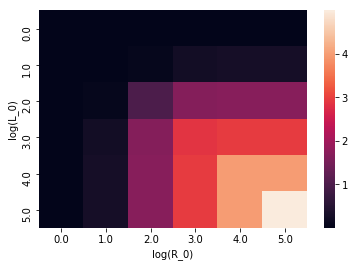

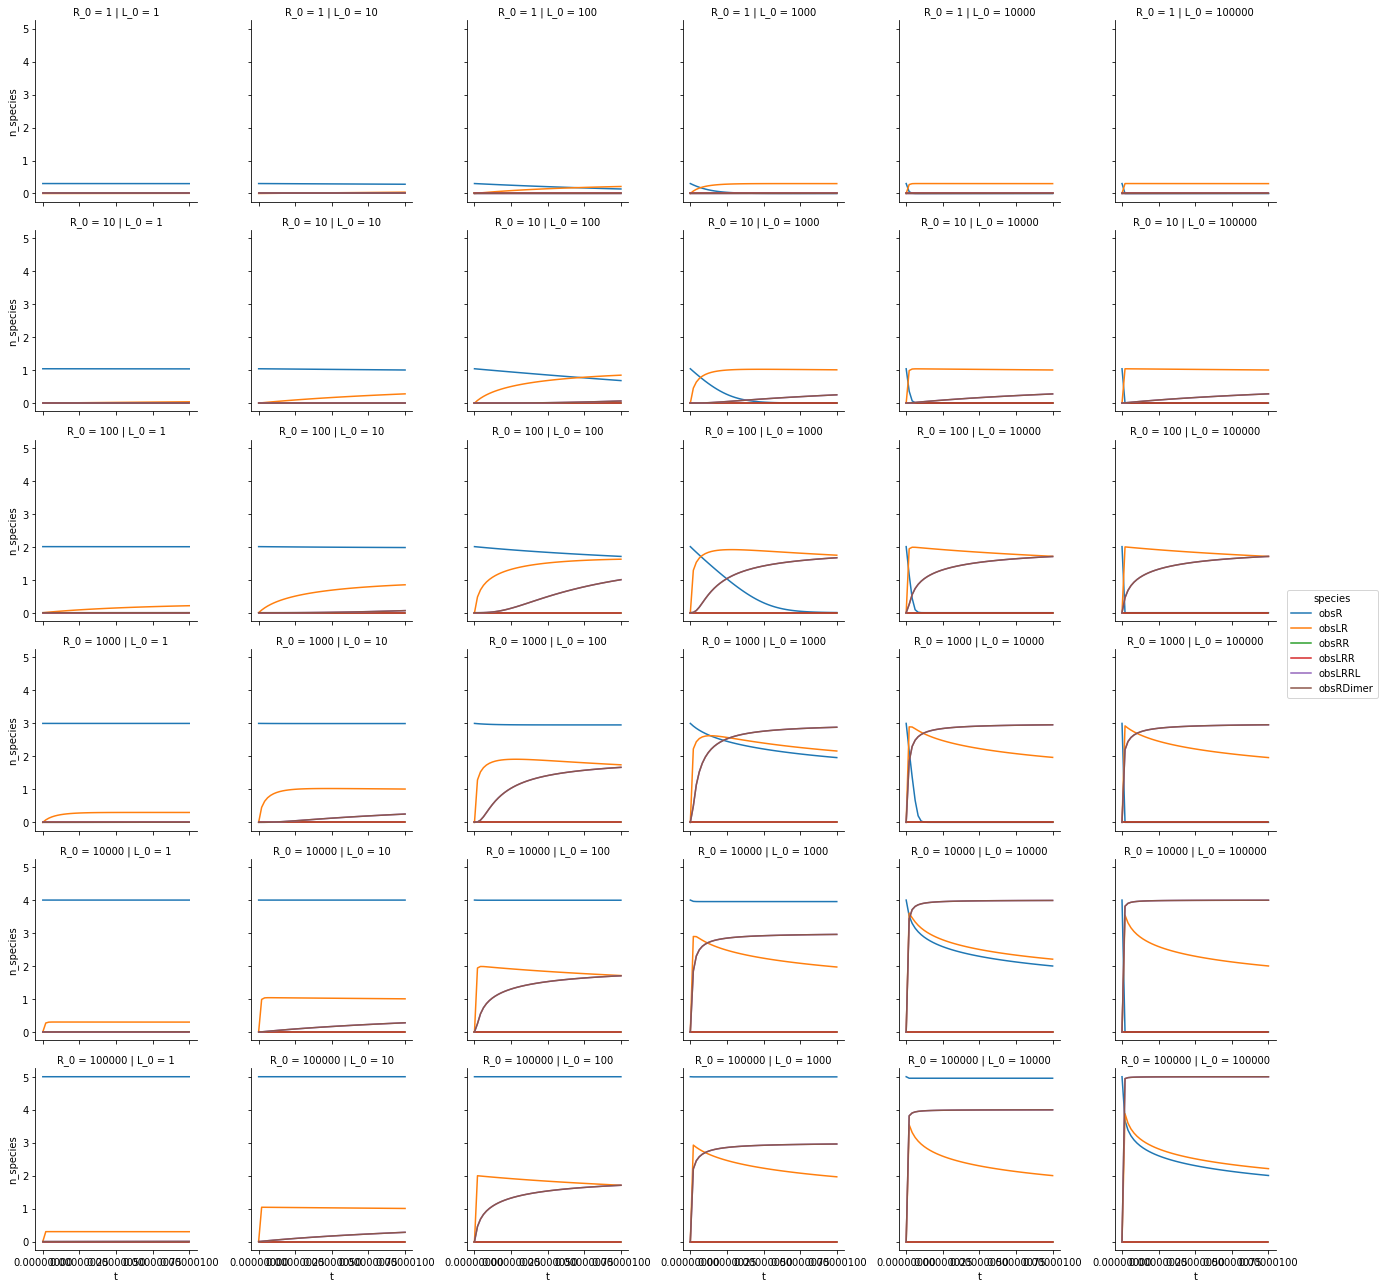

In [2]:
# SETUP
# titration amounts
L_concentrations = [10**x for x in range(6)] # 1 to 100000, which is micromolar range
R_concentrations = [10**x for x in range(6)]
observables = ['obsR', 'obsLR', 'obsRR', 'obsLRR', 'obsLRRL', 'obsRDimer']
condition_x = 'L_0'
condition_y = 'R_0'

# rate constants for the non-energy model
k_on_rl = 10e3
k_D_rl = 10e-09
k_off_rl = k_on_rl*k_D_rl
k_on_rr = 10e3
k_D_rr = 10e-09
k_off_rr = k_on_rr*k_D_rr

# DataFrame empty container for sim output
columns = [condition_x, condition_y, 'species', 't', 'n_species']
df = pd.DataFrame(dict([(x, []) for x in columns]))

# PROCEDURE: simulate and record output
for l, r in itertools.product(L_concentrations, R_concentrations):
    simres = ScipyOdeSimulator(m.model, tspan=t, param_values={'L_0': l, 
                                                               'R_0': r, 
                                                               'k_on_rl': k_on_rl, 
                                                               'k_off_rl': k_off_rl,
                                                               'k_on_rr': k_on_rr,
                                                               'k_off_rr': k_off_rr}).run()
    
    def one_observable(obs):
        # Transform values from each observable into tidy df
        return np.hstack([np.tile([l, r, obs], (len(t),1))] + map(lambda x: np.expand_dims(x, axis=1), [t, simres.all[obs]]))
    
    l_r_conc_df = pd.DataFrame(data=np.vstack((map(one_observable, observables))), columns=columns)
    df = pd.concat([df, l_r_conc_df])

# coerce non-numeric columns to numeric. This was messed up by the 'species' column
df[condition_x] = pd.to_numeric(df[condition_x])
df[condition_y] = pd.to_numeric(df[condition_y])
df['n_species'] = map(lambda x: math.log10(x+1), pd.to_numeric(df['n_species'])) # pseudo count +1 to prevent -inf
df['t'] = pd.to_numeric(df['t'])

# PROCEDURE: Generate LRRL Heatmap
def gen_heatmap(species):
    # Grab SS values
    lrrl_max = df[df['species'] == 'obs%s' % species].groupby([condition_x, condition_y])['n_species'].max()

    # Make tidy DF of max vals TODO simplify
    l_labels = np.array([map(math.log10, L_concentrations) for i in range(len(R_concentrations))]).flatten()
    r_labels = np.array([map(math.log10, R_concentrations) for j in range(len(L_concentrations))]).T.flatten()
    labels = ['log(%s)' % condition_x, 'log(%s)' % condition_y, 'log(%s)' % species]
    lrrl_matrix = pd.DataFrame({labels[0]: l_labels, labels[1]: r_labels, labels[2]: lrrl_max.values})
    lrrl_matrix = lrrl_matrix.pivot(**labels)
    
    # PROCEDURE: Heatmap
    sns.heatmap(lrrl_matrix).legend()
    plt.show()

gen_heatmap('LRRL')

# generate tiled plots of timescale for each of the l, r concentration combos        
g = sns.FacetGrid(df, col=condition_x, row=condition_y, hue='species')
g = (g.map(plt.plot, 't', 'n_species').add_legend())
plt.show()

    
    

In [ ]:
## NCA Polymerization
